In [ ]:
!pip install sklearn-crfsuite
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 875.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.

In [ ]:
import nltk
import gradio as gr
from sklearn.model_selection import KFold
from sklearn_crfsuite import CRF, metrics
from sklearn_crfsuite.metrics import flat_classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, fbeta_score, classification_report
)

nltk.download('brown')
nltk.download('universal_tagset')

# Load Brown corpus with universal tagset
tagged_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')



[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [ ]:
# Feature extraction function for words in a sentence
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.istitle()': word1.istitle(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word.istitle()': word1.istitle(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

In [ ]:
# Transform a sentence into a list of feature dictionaries
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# Extract labels from a tagged sentence
def sent2labels(sent):
    return [label for token, label in sent]

# Extract tokens from a tagged sentence
def sent2tokens(sent):
    return [token for token, label in sent]

# Prepare data
X = [sent2features(sent) for sent in tagged_sentences]
y = [sent2labels(sent) for sent in tagged_sentences]

# Cross-validation with KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize CRF model
crf = CRF(algorithm='lbfgs',
          c1=0.1,  # Coefficient for L1 regularization
          c2=0.1,  # Coefficient for L2 regularization
          max_iterations=100,
          all_possible_transitions=True)

y_true_list = []
y_pred_list = []

In [ ]:
# 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]
    X_test = [X[i] for i in test_idx]
    y_test = [y[i] for i in test_idx]

    crf.fit(X_train, y_train)

    y_pred = crf.predict(X_test)
    y_true_list.extend(y_test)
    y_pred_list.extend(y_pred)

    # Accuracy per fold
    accuracy = metrics.flat_accuracy_score(y_test, y_pred)
    print(f'Accuracy for Fold {fold + 1}: {accuracy}')

Accuracy for Fold 1: 0.9779590502127513
Accuracy for Fold 2: 0.9778273379432915
Accuracy for Fold 3: 0.9782098991159199
Accuracy for Fold 4: 0.9779553868221915
Accuracy for Fold 5: 0.9783944088787971


In [ ]:
# Calculate and print performance metrics
f0_5_score = 0
f1score = 0
f2score = 0
precision = 0
recall = 0

for i in range(5):
    f0_5_score += fbeta_score(y_true_list[i], y_pred_list[i], beta=0.5, average='weighted', zero_division=0)
    f1score += fbeta_score(y_true_list[i], y_pred_list[i], beta=1, average='weighted', zero_division=0)
    f2score += fbeta_score(y_true_list[i], y_pred_list[i], beta=2, average='weighted', zero_division=0)
    precision += precision_score(y_true_list[i], y_pred_list[i], average='weighted', zero_division=0)
    recall += recall_score(y_true_list[i], y_pred_list[i], average='weighted', zero_division=0)

# Average metrics across all folds
f0_5_score /= 5.0
f1score /= 5.0
f2score /= 5.0
precision /= 5.0
recall /= 5.0

# Print the averaged performance metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F0.5 Score: {f0_5_score}')
print(f'F1 Score: {f1score}')
print(f'F2 Score: {f2score}')

Precision: 0.9613636363636363
Recall: 0.9642857142857142
F0.5 Score: 0.9594547335148839
F1 Score: 0.9588888888888889
F2 Score: 0.9610569227691077


In [ ]:
# Classification report
labels = list(crf.classes_)
print(flat_classification_report(y_true_list, y_pred_list, labels=labels))

              precision    recall  f1-score   support

         DET       0.99      0.99      0.99    137019
        NOUN       0.97      0.98      0.98    275558
         ADJ       0.94      0.93      0.94     83721
        VERB       0.98      0.98      0.98    182750
         ADP       0.98      0.98      0.98    144766
           .       1.00      1.00      1.00    147565
         ADV       0.95      0.94      0.94     56239
        CONJ       0.99      1.00      1.00     38151
         PRT       0.95      0.94      0.95     29829
        PRON       0.99      0.99      0.99     49334
         NUM       0.98      0.97      0.97     14874
           X       0.80      0.47      0.59      1386

    accuracy                           0.98   1161192
   macro avg       0.96      0.93      0.94   1161192
weighted avg       0.98      0.98      0.98   1161192



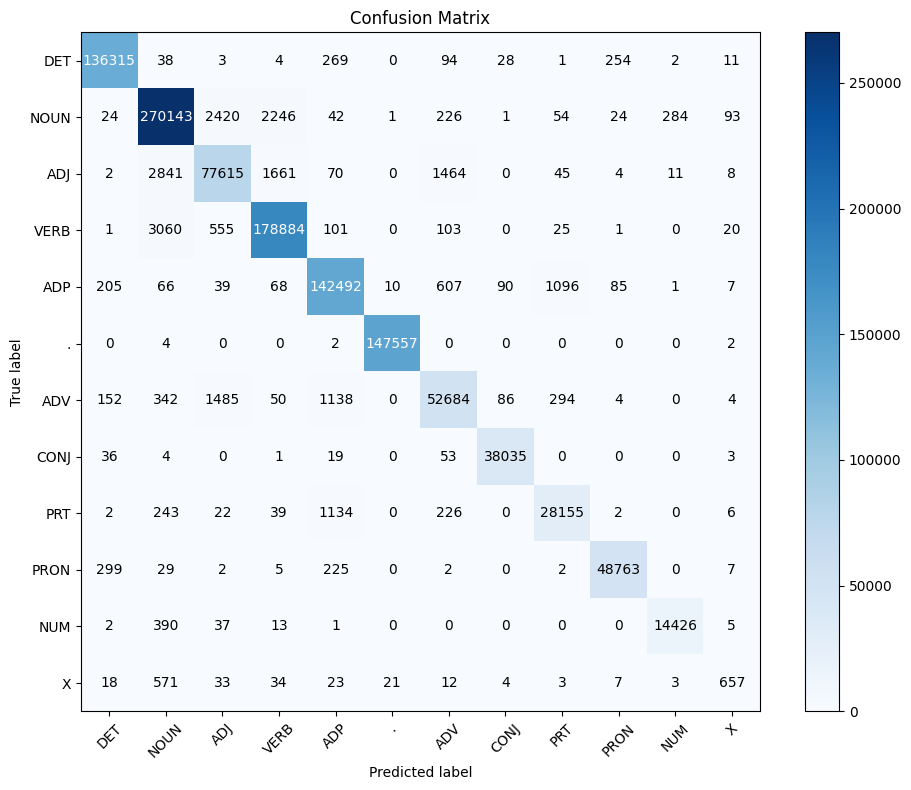

In [ ]:
# Confusion matrix
def plot_confusion_matrix(y_true_list, y_pred_list, labels):
    # Flatten the lists of lists into a single list
    y_true_flat = [item for sublist in y_true_list for item in sublist]
    y_pred_flat = [item for sublist in y_pred_list for item in sublist]

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Add numbers to the confusion matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(y_true_list, y_pred_list, labels)


Normalized Confusion Matrix
[[9.94862026e-01 2.77333800e-04 2.18947737e-05 2.91930316e-05
  1.96323138e-03 0.00000000e+00 6.86036243e-04 2.04351221e-04
  7.29825791e-06 1.85375751e-03 1.45965158e-05 8.02808370e-05]
 [8.70960016e-05 9.80348965e-01 8.78218016e-03 8.15073415e-03
  1.52418003e-04 3.62900007e-06 8.20154015e-04 3.62900007e-06
  1.95966004e-04 8.70960016e-05 1.03063602e-03 3.37497006e-04]
 [2.38888690e-05 3.39341384e-02 9.27067283e-01 1.98397057e-02
  8.36110414e-04 0.00000000e+00 1.74866521e-02 0.00000000e+00
  5.37499552e-04 4.77777380e-05 1.31388779e-04 9.55554759e-05]
 [5.47195622e-06 1.67441860e-02 3.03693570e-03 9.78845417e-01
  5.52667579e-04 0.00000000e+00 5.63611491e-04 0.00000000e+00
  1.36798906e-04 5.47195622e-06 0.00000000e+00 1.09439124e-04]
 [1.41607836e-03 4.55908155e-04 2.69400274e-04 4.69723554e-04
  9.84291892e-01 6.90769932e-05 4.19297349e-03 6.21692939e-04
  7.57083846e-03 5.87154442e-04 6.90769932e-06 4.83538953e-05]
 [0.00000000e+00 2.71066987e-05 0.000

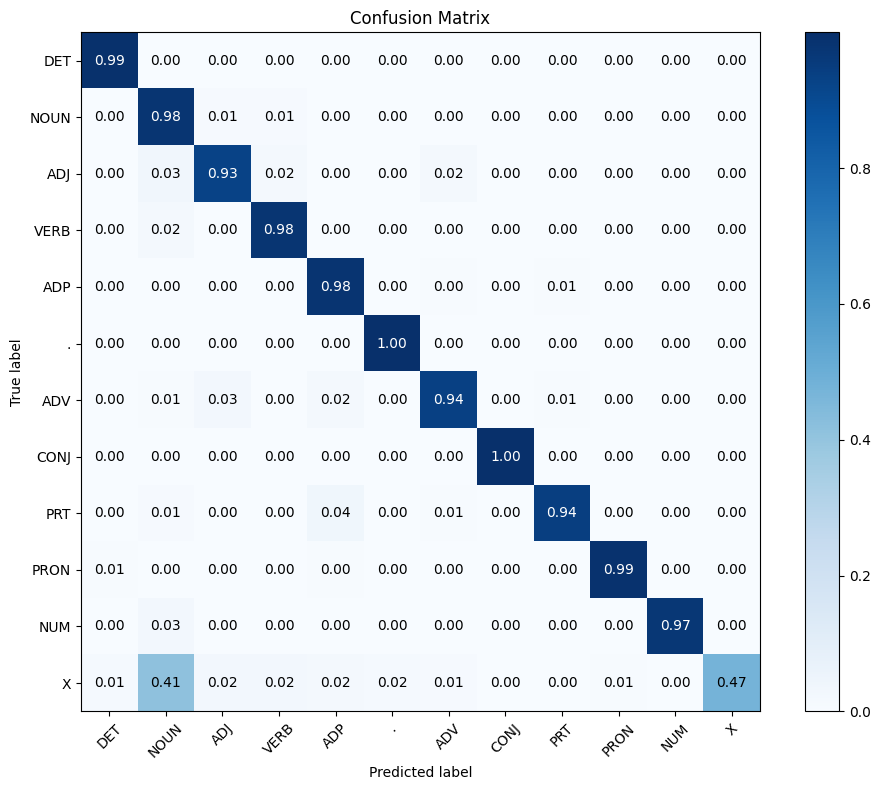

In [ ]:

# Confusion matrix
def plot_n_confusion_matrix(y_true_list, y_pred_list, labels, normalize=False):
    # Flatten the lists of lists into a single list
    y_true_flat = [item for sublist in y_true_list for item in sublist]
    y_pred_flat = [item for sublist in y_pred_list for item in sublist]

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Add numbers to the confusion matrix
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Call the function with normalization
plot_n_confusion_matrix(y_true_list, y_pred_list, labels, normalize=True)


In [ ]:
def predict_pos(sentence):
    sentence = sentence.lower().split()
    features = [word2features([(word, None)], 0) for word in sentence]
    predicted_tags = crf.predict([features])[0]
    return list(zip(sentence, predicted_tags))


# Gradio Interface
interface = gr.Interface(
    fn=predict_pos,  # Function to be called for predictions
    inputs="text",   # Text input
    outputs="json",  # Output format
    title="POS Tagger",
    description="Enter a sentence and get the POS tags"
)

# Launch the Gradio app
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d87e996dde852bb27e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
